In [42]:
import os
import glob
import re

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 600
import numpy as np
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt

In [2]:
id_map = pd.read_csv('/cephfs/users/annawoodard/gene-fusion/WABCS-U01_Samples_Phenotype_master2B.csv')

def parse_data(path):
    df = pd.read_table(path)
    sample = path.split('/')[7]
    patient = id_map[id_map['NGDx RNAseq Lib ID'] == sample[:-2]]['NBCS barcode'].iloc[0]
    
    df['sample'] = sample
    df['patient'] = patient
    
    return df

In [101]:
files = glob.glob('/cephfs/users/annawoodard/gene-fusion/starseqr/results_v3/*/ss_STAR-SEQR/ss_STAR-SEQR_candidates.txt')
dfs = [parse_data(f) for f in files]
starseqr_data = pd.concat(dfs)
starseqr_data = starseqr_data[starseqr_data['DISPOSITION'] == 'PASS']
starseqr_data['gene1'] = starseqr_data['LEFT_SYMBOL']
starseqr_data['gene2'] = starseqr_data['RIGHT_SYMBOL']
starseqr_data['chromosome1'] = starseqr_data.BRKPT_LEFT.str.extract(pat='(^\d.*)\:\d.*\:.*')
starseqr_data['chromosome2'] = starseqr_data.BRKPT_RIGHT.str.extract(pat='(^\d.*)\:\d.*\:.*')
# Transformation below is because starseqr is 0-indexed while the other callers are 1-indexed
starseqr_data['breakpoint1'] = starseqr_data.BRKPT_LEFT.str.extract(pat='^\d.*\:(\d.*)\:.*').astype(float).astype('Int64') + 1
starseqr_data.breakpoint1 = starseqr_data.chromosome1 + ':' + starseqr_data.breakpoint1.astype(str)
starseqr_data['breakpoint2'] = starseqr_data.BRKPT_RIGHT.str.extract(pat='^\d.*\:(\d.*)\:.*').astype(float).astype('Int64') + 1
starseqr_data.breakpoint2 = starseqr_data.chromosome2 + ':' + starseqr_data.breakpoint2.astype(str)
starseqr_data['name'] = starseqr_data[['gene1', 'gene2']].apply(lambda x: '--'.join(sorted(x)), axis=1)
starseqr_data['starseqr'] = True

In [102]:
files = glob.glob('/cephfs/users/annawoodard/gene-fusion/arriba/results_v3/*/fusions.tsv')
dfs = [parse_data(f) for f in files]
arriba_data = pd.concat(dfs)
#arriba_data[arriba_data.confidence.str.contains('medium|high')]
arriba_data.rename(columns={'#gene1': 'gene1'}, inplace=True)
arriba_data['name'] = arriba_data[['gene1', 'gene2']].apply(lambda x: '--'.join(sorted(x)), axis=1)
arriba_data['arriba'] = True

In [90]:
arriba_data[arriba_data.name.str.contains('TP53')]
arriba_data[arriba_data['sample'] == 'LIB-03335WT']

,gene1,gene2,strand1(gene/fusion),strand2(gene/fusion),breakpoint1,breakpoint2,site1,site2,type,direction1,direction2,split_reads1,split_reads2,discordant_mates,coverage1,coverage2,confidence,closest_genomic_breakpoint1,closest_genomic_breakpoint2,filters,fusion_transcript,reading_frame,peptide_sequence,read_identifiers,sample,patient,name,arriba
0,RP11-813C7.1,RBMS1,-/-,-/-,2:160169212,2:160303487,splice-site,splice-site,duplication,upstream,downstream,22,106,65,807,374,high,.,.,"duplicates(95),low_entropy(11),mismappers(1)",AATGACTCCCTCCACCTCCTGGTCTTTGTGAGTGATGCTGATTCTC...,.,.,.,LIB-03335WT,N010898,RP11-813C7.1--RBMS1,True
1,RP11-813C7.1,RBMS1,-/-,-/-,2:160172569,2:160303487,splice-site,splice-site,duplication,upstream,downstream,0,2,11,1050,374,high,.,.,duplicates(5),TGATGCAATTATGCAAGCTGCTGTGTGTAAG___GAAAAAATTGGC...,.,.,.,LIB-03335WT,N010898,RP11-813C7.1--RBMS1,True
2,ITGB6,RBMS1,-/-,-/-,2:160169212,2:160303487,splice-site,splice-site,duplication,upstream,downstream,22,106,65,807,374,high,.,.,"duplicates(95),low_entropy(11),mismappers(1)",AATGACTCCCTCCACCTCCTGGTCTTTGTGAGTGATGCTGATTCTC...,in-frame,NDSLHLLVFVSDADSHFGMDSKLAGIVIPNDGLCHLDSKNEYSMST...,.,LIB-03335WT,N010898,ITGB6--RBMS1,True
3,ITGB6,RBMS1,-/-,-/-,2:160172569,2:160303487,splice-site,splice-site,duplication,upstream,downstream,0,2,11,1050,374,high,.,.,duplicates(5),TGATGCAATTATGCAAGCTGCTGTGTGTAAG___GAAAAAATTGGC...,in-frame,DAIMQAAVCKEKIGWRNDSLHLLVFVSDADSHFGMDSKLAGIVIPN...,.,LIB-03335WT,N010898,ITGB6--RBMS1,True
4,STARD3,AC087491.2,+/+,+/-,17:39637231,17:39622205,splice-site,exon,inversion/3'-3',downstream,downstream,11,108,4,2312,501,high,.,.,"duplicates(39),inconsistently_clipped(9)",CTTCGCTCTCGGGGGCGGACTCAGCGGCGGAAGTGGCGCTGCCGGA...,.,.,.,LIB-03335WT,N010898,STARD3--AC087491.2,True
5,STARD3,PPP1R1B,+/+,+/-,17:39637231,17:39635026,splice-site,intron,inversion/3'-3',downstream,downstream,8,59,0,2312,1438,high,.,.,"duplicates(73),inconsistently_clipped(25),mism...",CCGCTTCGCTCTCGGGGGCGGACTCAGCGGCGGAAGTGGCGCTGCC...,.,.,.,LIB-03335WT,N010898,STARD3--PPP1R1B,True
6,STARD3,NEUROD2,+/+,-/-,17:39637231,17:39608065,splice-site,exon,inversion,downstream,downstream,1,30,2,2312,96,high,.,.,duplicates(9),GGCGGAAGTGGCGCTGCCGGAAGATCTTCTTCCGCTCTGAGGCGCT...,.,.,.,LIB-03335WT,N010898,STARD3--NEUROD2,True
7,STARD3,NEUROD2,+/+,-/-,17:39637231,17:39606604,splice-site,splice-site,inversion,downstream,downstream,2,10,1,2312,72,medium,.,.,duplicates(4),CCGCAGGCGAACGCAAGTCCCGCTTCGCTCTCGGGGGCGGACTCAG...,.,.,.,LIB-03335WT,N010898,STARD3--NEUROD2,True
8,CDK12,FBXL20,+/+,-/-,17:39501439,17:39343241,splice-site,splice-site,inversion,downstream,downstream,16,6,9,1546,245,high,.,.,"duplicates(7),mismappers(2)",CTTCGTCAGTTAATCCACCGAAGTGTTGTTAACATGAAGGAAATTG...,out-of-frame,LRQLIHRSVVNMKEIVTDKQDALDFKKDKGAFYLVFEYMDHDLMGL...,.,LIB-03335WT,N010898,CDK12--FBXL20,True
9,FBXL20,CDK12,-/-,+/+,17:39401361,17:39544249,splice-site,splice-site,inversion,upstream,upstream,0,1,0,287,1645,low,.,.,.,AACGGAGTGACCAAGAGCAGGTTTGAG|GTAGGAGCAACGGTGGGA...,out-of-frame,NGVTKSRFE|vgatvgmpseecsdvhqspltqslansvsftepkak...,.,LIB-03335WT,N010898,FBXL20--CDK12,True


In [91]:
arriba_data

,gene1,gene2,strand1(gene/fusion),strand2(gene/fusion),breakpoint1,breakpoint2,site1,site2,type,direction1,direction2,split_reads1,split_reads2,discordant_mates,coverage1,coverage2,confidence,closest_genomic_breakpoint1,closest_genomic_breakpoint2,filters,fusion_transcript,reading_frame,peptide_sequence,read_identifiers,sample,patient,name,arriba
0,RP11-813C7.1,RBMS1,-/-,-/-,2:160169212,2:160303487,splice-site,splice-site,duplication,upstream,downstream,22,106,65,807,374,high,.,.,"duplicates(95),low_entropy(11),mismappers(1)",AATGACTCCCTCCACCTCCTGGTCTTTGTGAGTGATGCTGATTCTC...,.,.,.,LIB-03335WT,N010898,RP11-813C7.1--RBMS1,True
1,RP11-813C7.1,RBMS1,-/-,-/-,2:160172569,2:160303487,splice-site,splice-site,duplication,upstream,downstream,0,2,11,1050,374,high,.,.,duplicates(5),TGATGCAATTATGCAAGCTGCTGTGTGTAAG___GAAAAAATTGGC...,.,.,.,LIB-03335WT,N010898,RP11-813C7.1--RBMS1,True
2,ITGB6,RBMS1,-/-,-/-,2:160169212,2:160303487,splice-site,splice-site,duplication,upstream,downstream,22,106,65,807,374,high,.,.,"duplicates(95),low_entropy(11),mismappers(1)",AATGACTCCCTCCACCTCCTGGTCTTTGTGAGTGATGCTGATTCTC...,in-frame,NDSLHLLVFVSDADSHFGMDSKLAGIVIPNDGLCHLDSKNEYSMST...,.,LIB-03335WT,N010898,ITGB6--RBMS1,True
3,ITGB6,RBMS1,-/-,-/-,2:160172569,2:160303487,splice-site,splice-site,duplication,upstream,downstream,0,2,11,1050,374,high,.,.,duplicates(5),TGATGCAATTATGCAAGCTGCTGTGTGTAAG___GAAAAAATTGGC...,in-frame,DAIMQAAVCKEKIGWRNDSLHLLVFVSDADSHFGMDSKLAGIVIPN...,.,LIB-03335WT,N010898,ITGB6--RBMS1,True
4,STARD3,AC087491.2,+/+,+/-,17:39637231,17:39622205,splice-site,exon,inversion/3'-3',downstream,downstream,11,108,4,2312,501,high,.,.,"duplicates(39),inconsistently_clipped(9)",CTTCGCTCTCGGGGGCGGACTCAGCGGCGGAAGTGGCGCTGCCGGA...,.,.,.,LIB-03335WT,N010898,STARD3--AC087491.2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,ARL5B,AC008697.1,+/+,+/+,10:18659683,5:159786092,splice-site,splice-site,translocation,downstream,upstream,0,4,1,3,40,high,.,.,"duplicates(20),inconsistently_clipped(1)",CCGCGGTGGGGGACCCGGCGCAGCGGCACCTGCTGCCGAGGGACCC...,out-of-frame,MGLIFAKLWSLFCNQ|gefgtifrirlpcclsmycn*,.,LIB-006806wt,Unknown,ARL5B--AC008697.1,True
2,ARHGEF9,"RP11-144M17.1(135227),RP13-34C21.1(75356)",-/-,./-,X:63697125,X:63223891,splice-site,intergenic,deletion,upstream,downstream,0,2,0,13,10,medium,.,.,duplicates(8),GTATAACAATGATGACCCCCACCTCAGCGAGATAGGACCCTGCTTC...,out-of-frame,YNNDDPHLSEIGPCFLEH|qqhgcrgrp*,.,LIB-006806wt,Unknown,"ARHGEF9--RP11-144M17.1(135227),RP13-34C21.1(75...",True
3,PSD3,INTS10,-/-,+/+,8:18765512,8:19851650,CDS,CDS,inversion,upstream,upstream,0,0,2,6,103,low,.,.,duplicates(4),CATTGCTTCACAAG___ATGG?GTCCATTGCCTTACCTGTGCAATA...,.,.,.,LIB-006806wt,Unknown,PSD3--INTS10,True
4,ENGASE,UBAP1L,+/+,-/-,17:79087837,15:65094568,3'UTR,CDS,translocation,downstream,downstream,0,0,2,39,24,low,.,.,duplicates(1),GTGAGGGAAGAGGCCACCAGGTGGCAGCACAGCCACACCCGTTCCC...,.,.,.,LIB-006806wt,Unknown,ENGASE--UBAP1L,True


Text(0.5, 0, 'fusion fragments per million total reads')

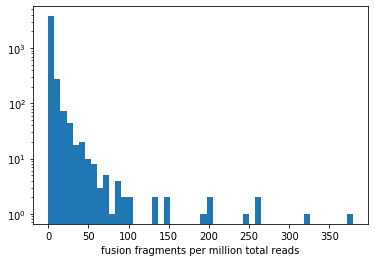

In [92]:
ax = arriba_data['split_reads1'].hist(bins=50)
ax.set_yscale('log')
ax.grid(False)
ax.set_xlabel('fusion fragments per million total reads')
#print('minimum FFPM: {:.1f}'.format(min(data['FFPM'])))

In [103]:
files = glob.glob('/cephfs/users/annawoodard/gene-fusion/star-fusion/results_v3/*/star-fusion.fusion_predictions.tsv')

dfs = [parse_data(f) for f in files]
starfusion_data = pd.concat(dfs)
#starfusion_data.rename(columns={'#FusionName': 'name'}, inplace=True)
starfusion_data['breakpoint1'] = starfusion_data['LeftBreakpoint'].str.rstrip('\:\+|\:\-').str.lstrip('chr')
starfusion_data['breakpoint2'] = starfusion_data['RightBreakpoint'].str.rstrip('\:\+|\:\-').str.lstrip('chr')
pattern = re.compile(r'\^.*')
starfusion_data['gene1'] = starfusion_data.LeftGene.str.replace(pattern, '')
starfusion_data['gene2'] = starfusion_data.RightGene.str.replace(pattern, '')
starfusion_data['name'] = starfusion_data[['gene1', 'gene2']].apply(lambda x: '--'.join(sorted(x)), axis=1)
starfusion_data['starfusion'] = True

In [104]:
starfusion_data[starfusion_data.name == 'OR51S1--TP53I11'].sort_values(['FFPM'], ascending=False)

,#FusionName,JunctionReadCount,SpanningFragCount,SpliceType,LeftGene,LeftBreakpoint,RightGene,RightBreakpoint,JunctionReads,SpanningFrags,LargeAnchorSupport,FFPM,LeftBreakDinuc,LeftBreakEntropy,RightBreakDinuc,RightBreakEntropy,annots,sample,patient,breakpoint1,breakpoint2,gene1,gene2,name,starfusion
5,OR51S1--TP53I11,14,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30529:156:C95L0ANXX:7:1316:1206:2615...,.,YES_LDAS,0.2822,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-008196wt,NWRONGID2_WAS_N011063,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,True
3,OR51S1--TP53I11,3,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30342:282:H3J57ADXY:1:2116:19993:450...,.,YES_LDAS,0.2701,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-006798wt,Unknown,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,True
14,OR51S1--TP53I11,13,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30529:156:C95L0ANXX:2:2105:4485:7743...,.,YES_LDAS,0.2476,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-008182wt,L000024,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,True
5,OR51S1--TP53I11,7,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30445:153:C8755ANXX:8:2314:3296:8361...,.,YES_LDAS,0.2203,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-04590wt,NWRONGID_WAS_N011024,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,True
22,OR51S1--TP53I11,16,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30529:156:C95L0ANXX:2:2310:8410:6740...,.,YES_LDAS,0.2108,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-008188wt,NWRONGID1_WAS_N011067,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,True
4,OR51S1--TP53I11,12,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30529:127:C7A7UANXX:2:1116:18425:242...,.,YES_LDAS,0.2084,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-04615wt,N010861,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,True
10,OR51S1--TP53I11,24,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30529:128:C7842ANXX:7:1215:4223:4767...,.,YES_LDAS,0.1947,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-04658wt,L000050,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,True
3,OR51S1--TP53I11,9,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30445:153:C8755ANXX:7:2106:11854:396...,.,YES_LDAS,0.1906,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-04618wt,N010870,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,True
6,OR51S1--TP53I11,7,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30529:156:C95L0ANXX:2:1309:1685:6410...,.,YES_LDAS,0.1905,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-008178wt,L000020,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,True
8,OR51S1--TP53I11,10,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30445:134:C636BACXX:4:2309:20422:863...,.,YES_LDAS,0.1865,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-03335WT,N010898,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,True


In [105]:
starfusion_data[starfusion_data.annots.str.contains('GTEx_recurrent_StarF2019')]['annots']

5    ["GTEx_recurrent_StarF2019","ChimerKB","INTERC...
6    ["GTEx_recurrent_StarF2019","ChimerKB","INTERC...
7    ["GTEx_recurrent_StarF2019","ChimerKB","INTERC...
8    ["GTEx_recurrent_StarF2019","ChimerKB","INTERC...
9    ["GTEx_recurrent_StarF2019","ChimerKB","INTERC...
0    ["GTEx_recurrent_StarF2019","ChimerKB","INTERC...
1    ["GTEx_recurrent_StarF2019","ChimerKB","INTERC...
2    ["GTEx_recurrent_StarF2019","ChimerKB","INTERC...
Name: annots, dtype: object

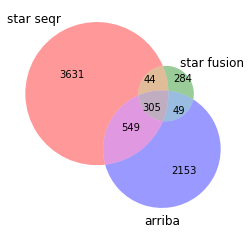

In [106]:
unique_starseqr = set(starseqr_data.name.tolist())
unique_starfusion = set(starfusion_data.name.tolist())
unique_arriba = set(arriba_data.name.tolist())

venn3([unique_starseqr, unique_starfusion, unique_arriba], set_labels = ('star seqr', 'star fusion', 'arriba'))
#plt.savefig('plots/fail_DBSNP_ppon_1kgenomes_venn.pdf', bbox_inches='tight')

In [120]:
#data = pd.concat([arriba_data, starseqr_data, starfusion_data], sort=False)
merge_keys = ['name', 'gene1', 'gene2', 'sample', 'patient']
data = pd.merge(arriba_data, starseqr_data, how='outer', on=merge_keys)
len(arriba_data), len(starseqr_data), len(data)
data[['gene1', 'gene2', 'arriba', 'starseqr']]
#data = pd.merge(data, starfusion_data, on=merge_keys)
#data.fillna({'arriba': False, 'starseqr': False, 'starfusion': False}, inplace=True)
#data[['gene1', 'gene2', 'breakpoint1', 'breakpoint2', 'arriba', 'starseqr', 'starfusion']]
#data.columns

,gene1,gene2,arriba,starseqr
0,RP11-813C7.1,RBMS1,True,NaN
1,RP11-813C7.1,RBMS1,True,NaN
2,ITGB6,RBMS1,True,True
3,ITGB6,RBMS1,True,True
4,STARD3,AC087491.2,True,NaN
...,...,...,...,...
8397,MAP2,LRCH1,NaN,True
8398,SLC33A1,POSTN,NaN,True
8399,GCNT2,TMPRSS3,NaN,True
8400,AP5Z1,RPS9,NaN,True


In [108]:
callers = ['arriba', 'starseqr', 'starfusion']

In [109]:
len(unique_starfusion), len(unique_starseqr), len(unique_arriba)

(682, 4529, 3056)

In [113]:
# Use 'ensemble' approach: accept any fusion if it is called by at least two callers
# This approach is extremely slow-- need to figure out how to vectorize
mask = []
for index, row in data[merge_keys + callers].iterrows():
    subset = data[data.name == row['name']]
    mask.append((int(np.any(subset.arriba)) + int(np.any(subset.starseqr)) + int(np.any(subset.starfusion))) > 1)

In [114]:
data[columns + callers]

,gene1,gene2,arriba,starseqr,starfusion
0,STARD3,NEUROD2,True,True,True
1,STARD3,NEUROD2,True,True,True
2,STARD3,NEUROD2,True,True,True
3,STARD3,NEUROD2,True,True,True
4,CDK12,FBXL20,True,True,True
...,...,...,...,...,...
1243,PRKAA1,RAI14,NaN,True,True
1244,IMMP2L,PWWP2B,NaN,True,True
1245,NCOA2,SH3YL1,NaN,True,True
1246,ZSWIM4,ZNF627,NaN,True,True


In [115]:
data[mask]

,gene1,gene2,strand1(gene/fusion),strand2(gene/fusion),breakpoint1_x,breakpoint2_x,site1,site2,type,direction1,direction2,split_reads1,split_reads2,discordant_mates,coverage1,coverage2,confidence,closest_genomic_breakpoint1,closest_genomic_breakpoint2,filters,fusion_transcript,reading_frame,peptide_sequence,read_identifiers,sample,patient,name,arriba,NAME,NREAD_SPANS,NREAD_JXNLEFT,NREAD_JXNRIGHT,FUSION_CLASS,SPLICE_TYPE,BRKPT_LEFT,BRKPT_RIGHT,LEFT_SYMBOL,RIGHT_SYMBOL,ANNOT_FORMAT,LEFT_ANNOT,RIGHT_ANNOT,DISTANCE,ASSEMBLED_CONTIGS,ASSEMBLY_CROSS_JXN,PRIMERS,ID,SPAN_CROSSHOM_SCORE,JXN_CROSSHOM_SCORE,OVERHANG_DIVERSITY,MINFRAG20,MINFRAG35,OVERHANG_MEANBQ,SPAN_MEANBQ,JXN_MEANBQ,OVERHANG_BQ15,SPAN_BQ15,JXN_BQ15,OVERHANG_MM,SPAN_MM,JXN_MM,OVERHANG_MEANLEN,SPAN_MEANLEN,JXN_MEANLEN,TPM_FUSION,TPM_LEFT,TPM_RIGHT,MAX_TRX_FUSION,DISPOSITION,chromosome1,chromosome2,breakpoint1_y,breakpoint2_y,starseqr,#FusionName,JunctionReadCount,SpanningFragCount,SpliceType,LeftGene,LeftBreakpoint,RightGene,RightBreakpoint,JunctionReads,SpanningFrags,LargeAnchorSupport,FFPM,LeftBreakDinuc,LeftBreakEntropy,RightBreakDinuc,RightBreakEntropy,annots,breakpoint1,breakpoint2,starfusion
0,STARD3,NEUROD2,+/+,-/-,17:39637231,17:39608065,splice-site,exon,inversion,downstream,downstream,1,30,2,2312,96,high,.,.,duplicates(9),GGCGGAAGTGGCGCTGCCGGAAGATCTTCTTCCGCTCTGAGGCGCT...,.,.,.,LIB-03335WT,N010898,NEUROD2--STARD3,True,STARD3--NEUROD2,17.0,14.0,14.0,READ_THROUGH,CANONICAL_SPLICING,17:39637230:+,17:39606603:-,STARD3,NEUROD2,Symbol:Transcript:Strand:Exon_No:Dist_to_Exon:...,"STARD3:ENST00000580611.5:+:1:0:-1:9522,STARD3:...","NEUROD2:ENST00000302584.4:-:2:0:0:1149,NEUROD2...",30627.0,CTCGGCCAACGTGGCCTCCGTCCCCTCTTCTCCACGGAGAGGGACT...,True,"GCTACTGAGGCCGCGGAG,GAACTTGGGCACGTCCGAG",17:39637232:+:17:39606605:-:3:1,0.0,0.0,11.0,11.0,7.0,32.928571,33.411765,28.142857,26.0,34.0,48.0,0.071429,0.588235,1.071429,42.571429,96.382353,76.642857,6.442550,NaN,2.310134,ENST00000585214.5--ENST00000580874.1|70,PASS,17,17,17:39637231,17:39606604,True,STARD3--NEUROD2,46,3,INCL_NON_REF_SPLICE,STARD3^ENSG00000131748.16,chr17:39637231:+,NEUROD2^ENSG00000171532.5,chr17:39608065:-,NRUSCA-WDL30445:134:C636BACXX:2:2109:2674:2047...,NRUSCA-WDL30445:134:C636BACXX:3:2114:3677:2588...,YES_LDAS,0.9141,GT,1.8892,AG,1.8323,"[""INTRACHROMOSOMAL[chr17:0.03Mb]"",""LOCAL_INVER...",17:39637231,17:39608065,True
1,STARD3,NEUROD2,+/+,-/-,17:39637231,17:39608065,splice-site,exon,inversion,downstream,downstream,1,30,2,2312,96,high,.,.,duplicates(9),GGCGGAAGTGGCGCTGCCGGAAGATCTTCTTCCGCTCTGAGGCGCT...,.,.,.,LIB-03335WT,N010898,NEUROD2--STARD3,True,STARD3--NEUROD2,17.0,14.0,14.0,READ_THROUGH,CANONICAL_SPLICING,17:39637230:+,17:39606603:-,STARD3,NEUROD2,Symbol:Transcript:Strand:Exon_No:Dist_to_Exon:...,"STARD3:ENST00000580611.5:+:1:0:-1:9522,STARD3:...","NEUROD2:ENST00000302584.4:-:2:0:0:1149,NEUROD2...",30627.0,CTCGGCCAACGTGGCCTCCGTCCCCTCTTCTCCACGGAGAGGGACT...,True,"GCTACTGAGGCCGCGGAG,GAACTTGGGCACGTCCGAG",17:39637232:+:17:39606605:-:3:1,0.0,0.0,11.0,11.0,7.0,32.928571,33.411765,28.142857,26.0,34.0,48.0,0.071429,0.588235,1.071429,42.571429,96.382353,76.642857,6.442550,NaN,2.310134,ENST00000585214.5--ENST00000580874.1|70,PASS,17,17,17:39637231,17:39606604,True,STARD3--NEUROD2,14,3,ONLY_REF_SPLICE,STARD3^ENSG00000131748.16,chr17:39637231:+,NEUROD2^ENSG00000171532.5,chr17:39606604:-,NRUSCA-WDL30445:134:C636BACXX:2:1313:10457:715...,NRUSCA-WDL30445:134:C636BACXX:3:2114:3677:2588...,YES_LDAS,0.3171,GT,1.8892,AG,1.8295,"[""INTRACHROMOSOMAL[chr17:0.03Mb]"",""LOCAL_INVER...",17:39637231,17:39606604,True
2,STARD3,NEUROD2,+/+,-/-,17:39637231,17:39606604,splice-site,splice-site,inversion,downstream,downstream,2,10,1,2312,72,medium,.,.,duplicates(4),CCGCAGGCGAACGCAAGTCCCGCTTCGCTCTCGGGGGCGGACTCAG...,.,.,.,LIB-03335WT,N010898,NEUROD2--STARD3,True,STARD3--NEUROD2,17.0,14.0,14.0,READ_THROUGH,CANONICAL_SPLICING,17:39637230:+,17:39606603:-,STARD3,NEUROD2,Symbol:Transcript:Strand:Exon_No:Dist_to_Exon:...,"STARD3:ENST00000580611.5:+:1:0

In [17]:
unique_fusions = data[columns].drop_duplicates()

In [18]:
cutflow = {}

In [19]:
# tcga.normal.id appears to be identical list
tcga_normal = pd.read_table('/cephfs/users/annawoodard/gene-fusion/CPTAC3-RNA-related-pipeline/FilterDatabase/tcga.normal.txt', names=['cancer', 'sample', 'fusion'])
cutflow['tcga normal'] = data.loc[data['name'].isin(tcga_normal.fusion), 'name']

In [20]:
noncancer_cell = pd.read_table('/cephfs/users/annawoodard/gene-fusion/CPTAC3-RNA-related-pipeline/FilterDatabase/noncancer_cell.txt', names=['fusion'])
cutflow['noncancer cell'] = data.loc[data['name'].isin(noncancer_cell.fusion), 'name']

In [21]:
gtex_or_paralogue = pd.read_table('/cephfs/users/annawoodard/gene-fusion/CPTAC3-RNA-related-pipeline/FilterDatabase/blacklist.manual', names=['fusion'])
cutflow['gtex or paralogue'] = data.loc[data['name'].isin(gtex_or_paralogue.fusion), 'name']

Text(0.5, 1.0, 'unique fusions filtered')

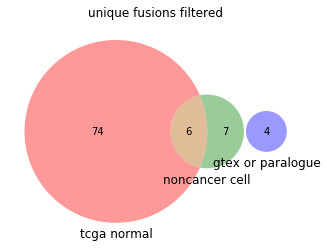

In [22]:
items = cutflow.items()
venn3([set(values) for key, values in items], set_labels = [key for key, values in items])
plt.title('unique fusions filtered')

In [23]:
print('{} fusions filtered / {} total fusions'.format(
    sum([len(values) for values in cutflow.values()]),
    len(data)
    )
)

491 fusions filtered / 18005 total fusions


In [24]:
data[mask].to_parquet('/cephfs/users/annawoodard/gene-fusion/fusion_ensemble.parquet')

In [57]:
union = pd.concat([starseqr_data[starseqr_data['DISPOSITION'] == 'PASS'], arriba_data, starseqr_data], sort=False)

In [58]:
union.to_parquet('/cephfs/users/annawoodard/gene-fusion/fusion_union.parquet')

In [61]:
# Alternate 'ensemble' approach: accept any fusion if it is called by starfusion, or both starseqr and arriba
# This approach is extremely slow-- need to figure out how to vectorize
mask = []
for index, row in data[columns + callers].iterrows():
    if row.starfusion == True:
        mask.append(True)
    else:
        subset = data[(data.gene1 == row.gene1) & (data.gene2 == row.gene2) & (data.breakpoint1 == row.breakpoint1) & (data.breakpoint2 == row.breakpoint2)]
        mask.append((int(np.any(subset.arriba)) + int(np.any(subset.starseqr)) > 1))